In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from jcopdl.callback import Callback, set_config

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Import Data

In [3]:
df = pd.read_csv("risk_factors_cervical_cancer.csv")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'risk_factors_cervical_cancer.csv'

In [6]:
df.isnull().values.sum()

0

In [7]:
df.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

In [8]:
for d in df.columns:
    df[d] = df[d].apply(lambda x: None if x == "?" else x)

In [9]:
df.isnull().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

In [10]:
df.drop(columns=["STDs: Time since first diagnosis", "STDs: Time since last diagnosis"], inplace=True)

In [11]:
imputer = SimpleImputer(strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Splitting Data

In [12]:
X = df.drop(columns=["Hinselmann", "Schiller", "Citology", "Biopsy"]).values
y = df[["Hinselmann", "Schiller", "Citology", "Biopsy"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((686, 30), (172, 30), (686, 4), (172, 4))

In [13]:
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [14]:
train_set = TensorDataset(X_train, y_train)
test_set = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)

In [15]:
X_train.shape

torch.Size([686, 30])

# Model

In [35]:
model = nn.Sequential(
    nn.Linear(30,8),
    nn.ReLU(),
    nn.Dropout(.2),
    
    nn.Linear(8,8),
    nn.ReLU(),
    nn.Dropout(.1),
    
    # nn.Linear(16,8),
    # nn.ReLU(),
    # nn.Dropout(.2),
    
    nn.Linear(8,4),
    nn.Sigmoid()
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
criterion = nn.BCELoss() # model diakhiri sigmoid -> binary clf, multilabel clf
# criterion = nn.NLLLoss() # model diakhiri logsoftmax -> multiclass clf
callback = Callback(model, outdir="model")

# Training

In [38]:
from tqdm.auto import tqdm
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature) # feedforward
        loss = criterion(output, target)
        if mode == "train":
            loss.backward() # backpropragation
            optimizer.step() # update weight
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]

    cost = cost / len(dataset)
    return cost



Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.7878 | Test_cost  = 0.6872 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.7130 | Test_cost  = 0.6250 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6623 | Test_cost  = 0.5753 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5986 | Test_cost  = 0.5305 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5623 | Test_cost  = 0.4886 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.5081 | Test_cost  = 0.4501 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4700 | Test_cost  = 0.4154 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4355 | Test_cost  = 0.3865 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4288 | Test_cost  = 0.3620 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.3906 | Test_cost  = 0.3417 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3885 | Test_cost  = 0.3254 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.3710 | Test_cost  = 0.3117 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3360 | Test_cost  = 0.3005 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3433 | Test_cost  = 0.2908 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3247 | Test_cost  = 0.2819 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3177 | Test_cost  = 0.2747 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3096 | Test_cost  = 0.2695 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3137 | Test_cost  = 0.2654 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3098 | Test_cost  = 0.2622 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.3011 | Test_cost  = 0.2596 | 


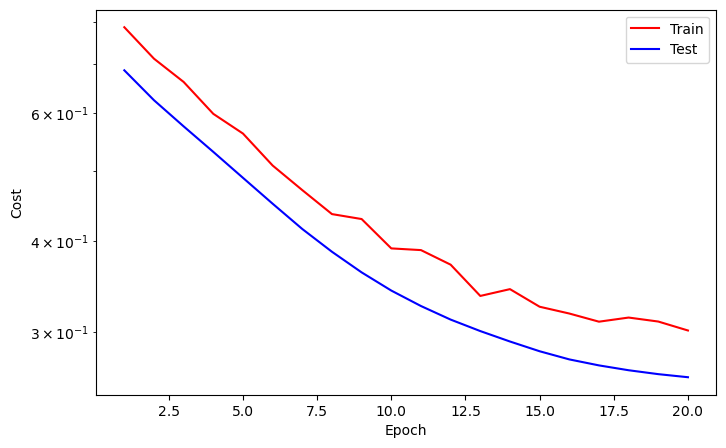

Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.2848 | Test_cost  = 0.2573 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.3010 | Test_cost  = 0.2553 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.3028 | Test_cost  = 0.2537 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.2959 | Test_cost  = 0.2521 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.2875 | Test_cost  = 0.2508 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.2853 | Test_cost  = 0.2496 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.2860 | Test_cost  = 0.2485 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.2710 | Test_cost  = 0.2473 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.2799 | Test_cost  = 0.2463 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.2929 | Test_cost  = 0.2455 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.2723 | Test_cost  = 0.2447 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.2865 | Test_cost  = 0.2442 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.2841 | Test_cost  = 0.2437 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.2603 | Test_cost  = 0.2432 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.2734 | Test_cost  = 0.2426 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.2709 | Test_cost  = 0.2422 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.2647 | Test_cost  = 0.2413 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.2687 | Test_cost  = 0.2404 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.2757 | Test_cost  = 0.2396 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.2575 | Test_cost  = 0.2386 | 


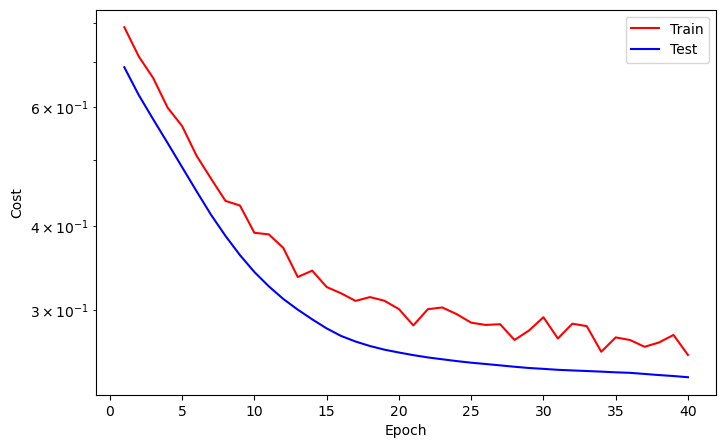

Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.2646 | Test_cost  = 0.2372 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.2700 | Test_cost  = 0.2359 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.2558 | Test_cost  = 0.2342 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.2625 | Test_cost  = 0.2325 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.2676 | Test_cost  = 0.2311 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 0.2631 | Test_cost  = 0.2305 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 0.2803 | Test_cost  = 0.2305 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 0.2648 | Test_cost  = 0.2303 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 0.2608 | Test_cost  = 0.2299 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 0.2599 | Test_cost  = 0.2295 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 0.2543 | Test_cost  = 0.2287 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 0.2657 | Test_cost  = 0.2282 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 0.2635 | Test_cost  = 0.2278 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 0.2533 | Test_cost  = 0.2274 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 0.2595 | Test_cost  = 0.2267 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 0.2478 | Test_cost  = 0.2261 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 0.2734 | Test_cost  = 0.2261 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 0.2526 | Test_cost  = 0.2259 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 0.2600 | Test_cost  = 0.2257 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 0.2589 | Test_cost  = 0.2252 | 


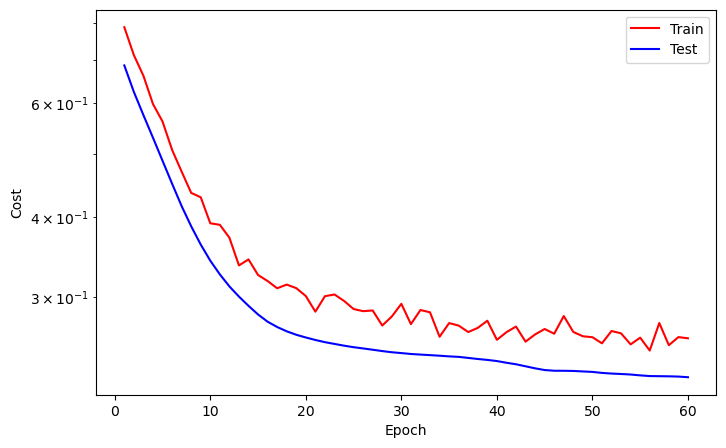

Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 0.2607 | Test_cost  = 0.2250 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 0.2610 | Test_cost  = 0.2253 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2250


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 0.2551 | Test_cost  = 0.2250 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 0.2544 | Test_cost  = 0.2249 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 0.2574 | Test_cost  = 0.2242 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 0.2557 | Test_cost  = 0.2240 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 0.2517 | Test_cost  = 0.2237 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 0.2543 | Test_cost  = 0.2234 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 0.2579 | Test_cost  = 0.2229 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 0.2654 | Test_cost  = 0.2230 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2229


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 0.2520 | Test_cost  = 0.2225 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 0.2575 | Test_cost  = 0.2226 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2225


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 0.2528 | Test_cost  = 0.2221 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 0.2540 | Test_cost  = 0.2219 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 0.2436 | Test_cost  = 0.2216 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 0.2494 | Test_cost  = 0.2210 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 0.2516 | Test_cost  = 0.2208 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 0.2511 | Test_cost  = 0.2208 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 0.2573 | Test_cost  = 0.2207 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 0.2450 | Test_cost  = 0.2208 | 


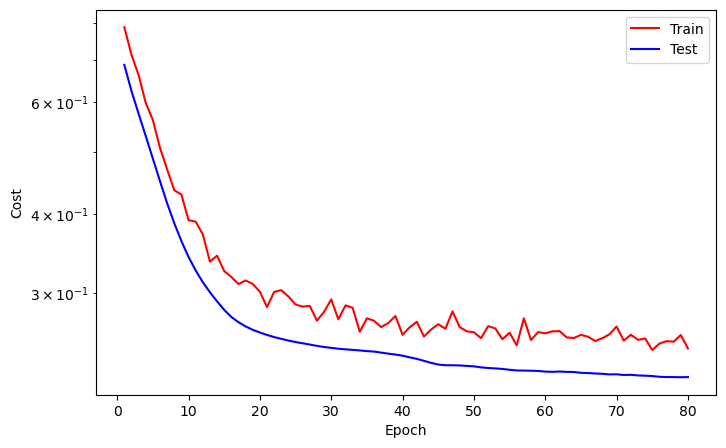

==> EarlyStop patience =  1 | Best test_cost: 0.2207


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 0.2562 | Test_cost  = 0.2205 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 0.2429 | Test_cost  = 0.2201 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 0.2503 | Test_cost  = 0.2195 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 0.2380 | Test_cost  = 0.2190 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 0.2597 | Test_cost  = 0.2180 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 0.2433 | Test_cost  = 0.2178 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 0.2477 | Test_cost  = 0.2178 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 0.2387 | Test_cost  = 0.2174 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 0.2488 | Test_cost  = 0.2174 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2174


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 0.2581 | Test_cost  = 0.2178 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2174


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 0.2513 | Test_cost  = 0.2176 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2174


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 0.2480 | Test_cost  = 0.2173 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 0.2518 | Test_cost  = 0.2165 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 0.2499 | Test_cost  = 0.2177 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2165


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 0.2498 | Test_cost  = 0.2174 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2165


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 0.2407 | Test_cost  = 0.2159 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 0.2450 | Test_cost  = 0.2150 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 0.2422 | Test_cost  = 0.2149 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 0.2362 | Test_cost  = 0.2144 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 0.2369 | Test_cost  = 0.2138 | 


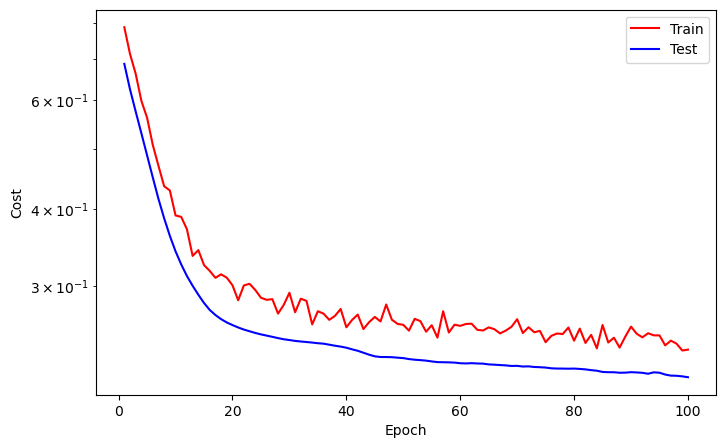

Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 0.2391 | Test_cost  = 0.2139 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2138


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 0.2427 | Test_cost  = 0.2133 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 0.2460 | Test_cost  = 0.2137 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2133


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 0.2433 | Test_cost  = 0.2143 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2133


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 0.2327 | Test_cost  = 0.2141 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2133


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 0.2386 | Test_cost  = 0.2129 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 0.2380 | Test_cost  = 0.2118 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 0.2423 | Test_cost  = 0.2110 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 0.2348 | Test_cost  = 0.2106 | 


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 0.2404 | Test_cost  = 0.2118 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2106


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 0.2296 | Test_cost  = 0.2112 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2106


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 0.2402 | Test_cost  = 0.2115 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2106


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 0.2432 | Test_cost  = 0.2122 | 
==> EarlyStop patience =  4 | Best test_cost: 0.2106


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 0.2326 | Test_cost  = 0.2118 | 
==> EarlyStop patience =  5 | Best test_cost: 0.2106
==> Execute Early Stopping at epoch: 114 | Best test_cost: 0.2106
==> Best model is saved at model


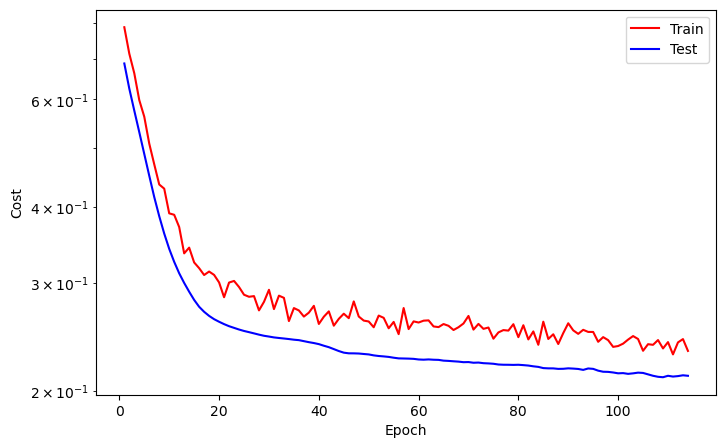

In [36]:
while True:
    train_cost = loop_fn("train", train_set, train_loader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, test_loader, model, criterion, optimizer, device)
    # Logging
    callback.log(train_cost, test_cost)
    # Save CheckPoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break